# Data preprocessing

## Configuration

In [1]:
INPUT_FILE_NAME = "vale3.csv"
DATA_USE_COLONS = [0, 1]
SEASON_WINDOW_SIZE = 30
DIFFERENCE_FEATURES_NUM = 1

## Prepare Environment

In [2]:
# Data analysis and data wrangling
import pandas as pd

# Plotting
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Other
import warnings
import pprint
import os

### Set Config

In [3]:
RAW_DATA_DIR = os.curdir + "/data/raw/"
PROCESSED_DATA_DIR = os.curdir + "/data/processed/"

In [4]:
%matplotlib inline
%load_ext autoreload

# pyplot
plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rc('figure', figsize = (16, 8))
plt.rc('font', size = 15)
plt.rc('legend', fontsize = 15)

# seaborn
rc = { 'savefig.dpi': 500, 
       'figure.autolayout': True, 
       'figure.figsize': [17, 12], 
       'axes.labelsize': 18,
       'axes.titlesize': 18, 
       'font.size': 10, 
       'lines.linewidth': 1.0, 
       'lines.markersize': 8, 
       'legend.fontsize': 15,
       'xtick.labelsize': 15, 
       'ytick.labelsize': 15 }

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True, 
        rc=rc)

# pandas
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

### Load Data

In [5]:
raw_df = pd.read_csv(
    RAW_DATA_DIR + INPUT_FILE_NAME,
    encoding = 'utf8',
    delimiter = ',',
    usecols = DATA_USE_COLONS,
    header = 0,
    names = ['date', 'price'],
    verbose = True
)

raw_df.head()

Tokenization took: 0.50 ms
Type conversion took: 1.00 ms
Parser memory cleanup took: 0.00 ms


,date,price
0,"Jun 19, 2020",55.17
1,"Jun 18, 2020",56.17
2,"Jun 17, 2020",56.20
3,"Jun 16, 2020",55.39
4,"Jun 15, 2020",53.88


## Data Preparation

- Transform data from YYYY-MM-DD fromat (`date` -> `datetime64`)
- Set date as index

In [6]:
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df.index = raw_df['date']
raw_df.info()
raw_df.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2020-06-19 to 2010-05-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2495 non-null   datetime64[ns]
 1   price   2495 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 58.5 KB


DatetimeIndex(['2020-06-19', '2020-06-18', '2020-06-17', '2020-06-16',
               '2020-06-15', '2020-06-12', '2020-06-10', '2020-06-09',
               '2020-06-08', '2020-06-05',
               ...
               '2010-06-02', '2010-06-01', '2010-05-31', '2010-05-28',
               '2010-05-27', '2010-05-26', '2010-05-25', '2010-05-24',
               '2010-05-21', '2010-05-20'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)

### Verify Data Quality

#### Check for outliers

In [7]:
def plot_box_plot(df: 'dataframe', data_set_name: str, xlim=None):
    fig, ax = plt.subplots(figsize=(18, 10))

    if xlim is not None:
        plt.xlim(*xlim)
    
    plt.title(f"Horizontal Boxplot {data_set_name}")
        
    plt.ylabel('Dependent Variables')
    plt.xlabel('Measurement x')
    ax = sns.boxplot(
        data = df,
        orient = 'h', 
        palette = 'Set2',
        notch = False,
        sym = 'rs'
    )
    plt.show()

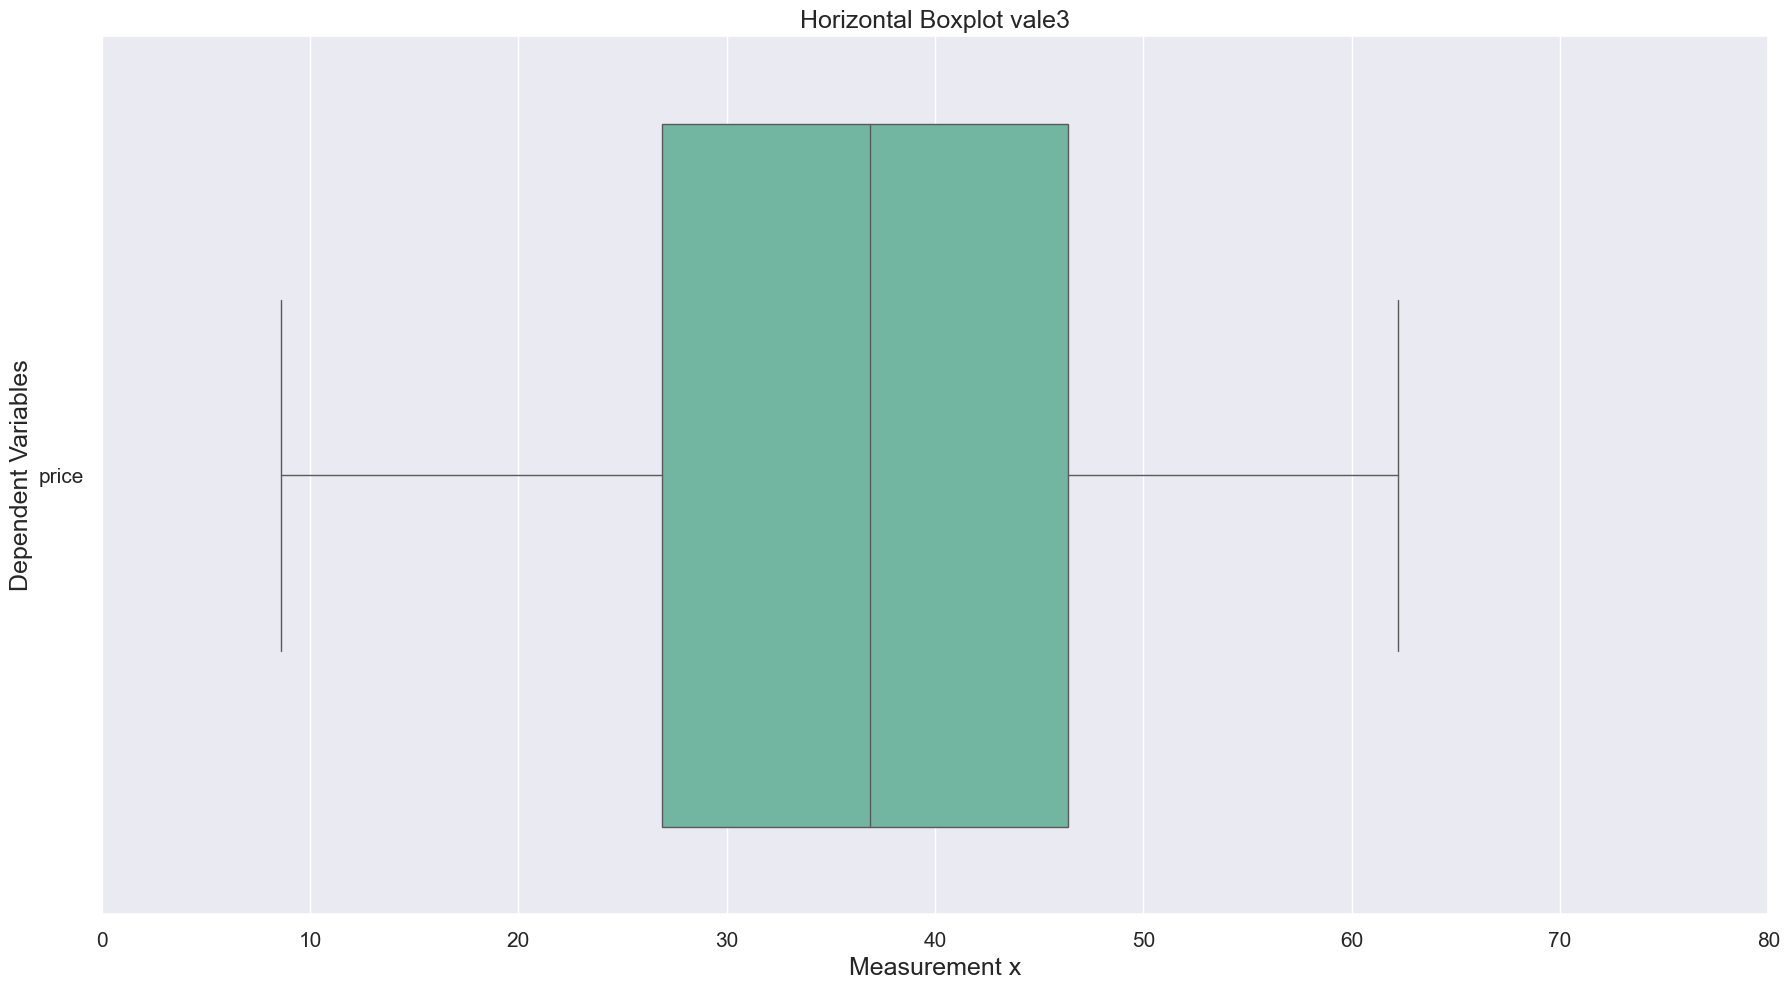

In [8]:
plot_box_plot(raw_df, INPUT_FILE_NAME.removesuffix('.csv'), (0, 80))

## Data Understanding: Statistics and Plot
- Distribution
- Seasonality
- Trend
- Risiduals

#### Distribution

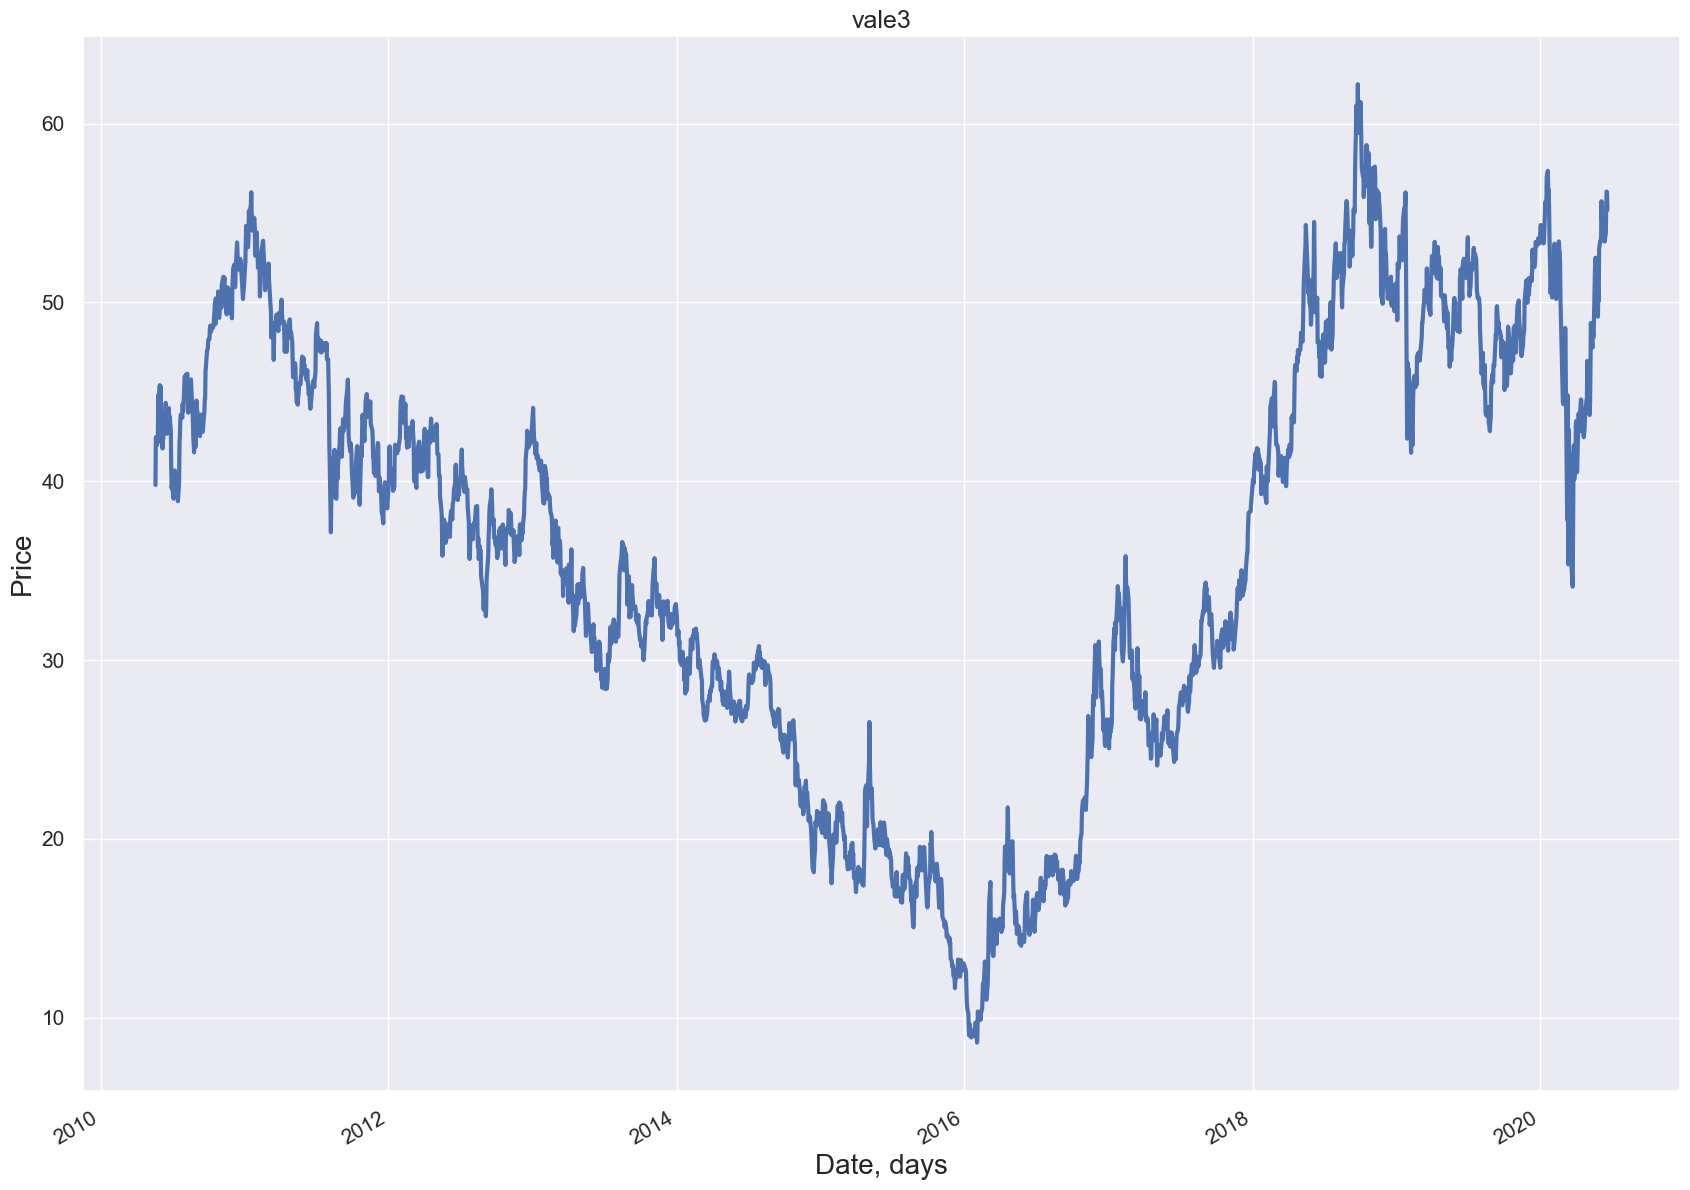

In [9]:
distr_line = raw_df['price'].plot(linewidth=3)

plt.title(INPUT_FILE_NAME.removesuffix('.csv'))
plt.xlabel('Date, days', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.grid(True)

## Time series decomposition

In [10]:
decomposition = seasonal_decompose(raw_df['price'], period = SEASON_WINDOW_SIZE, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

<AxesSubplot:xlabel='date', ylabel='Residuals'>

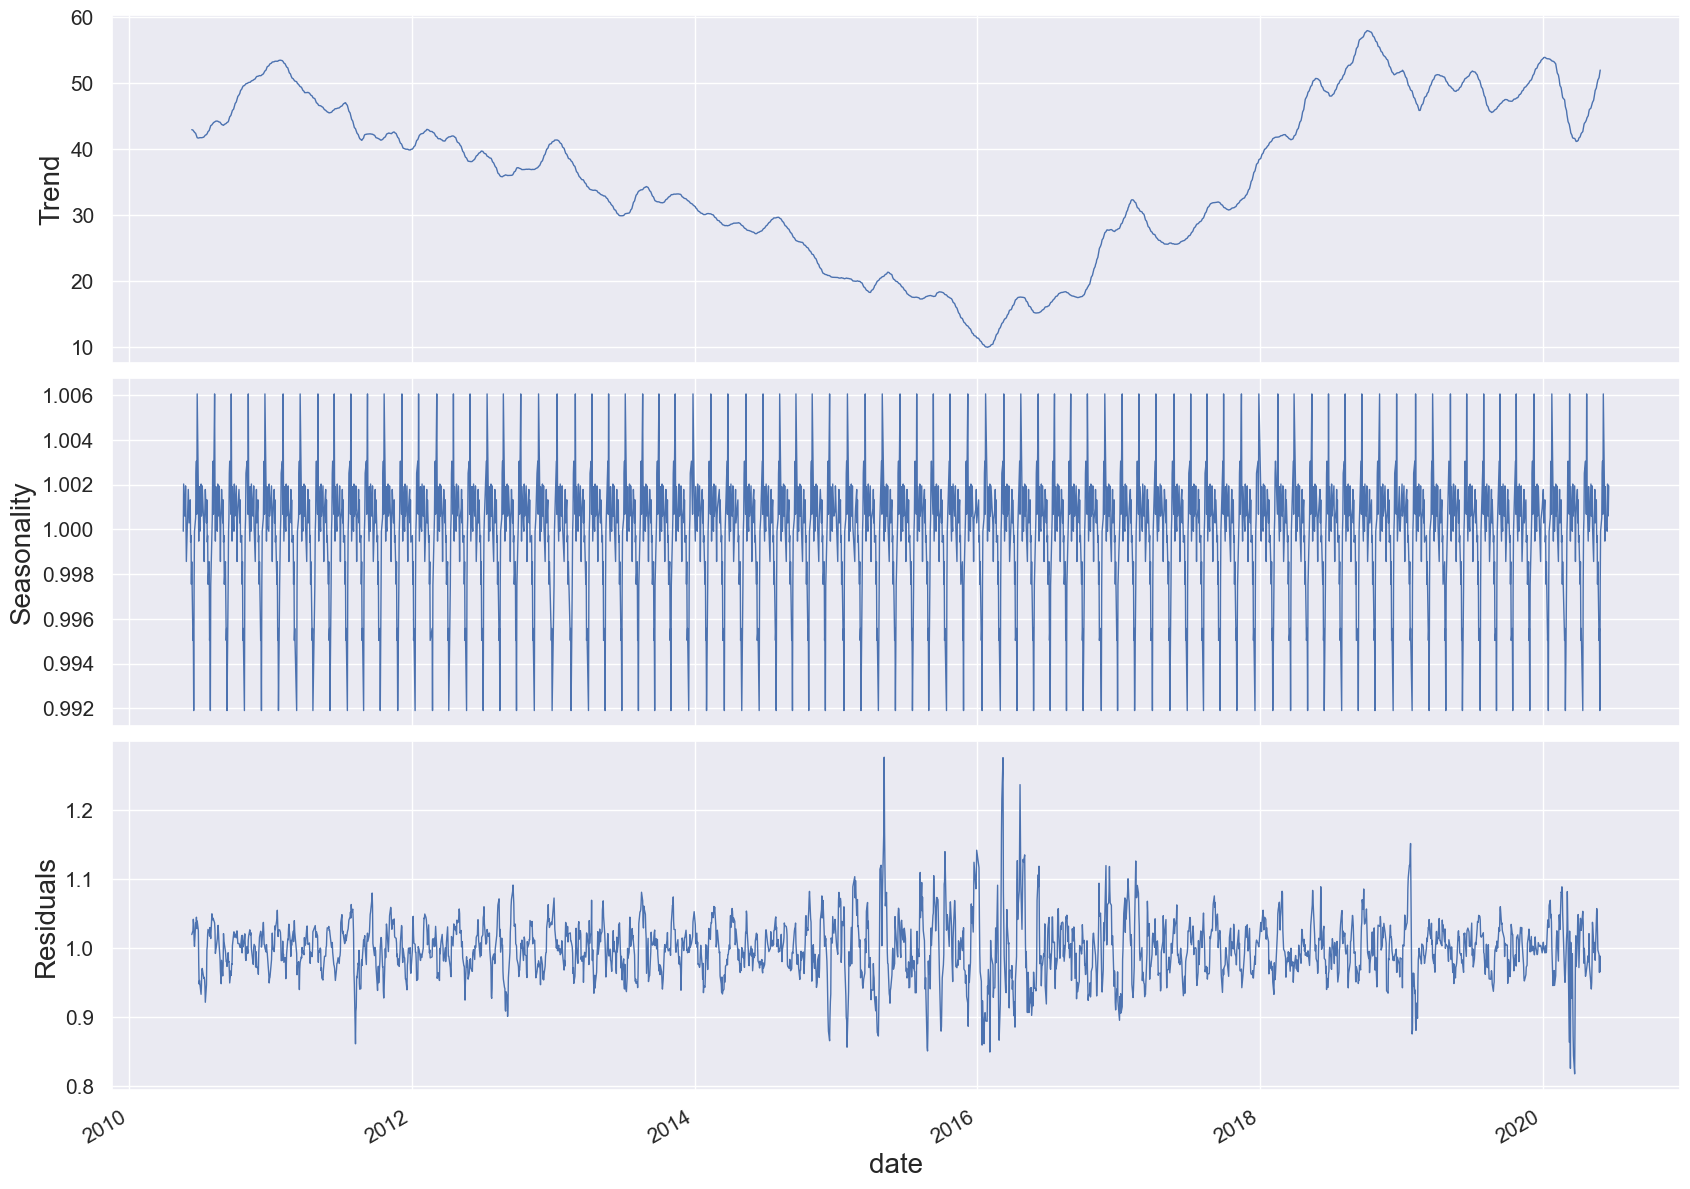

In [11]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)

axes[0].set_ylabel('Trend', fontsize=20)
axes[1].set_ylabel('Seasonality', fontsize=20)
axes[2].set_ylabel('Residuals', fontsize=20)
axes[2].set_xlabel('Time, days', fontsize=20)

decomposition.trend.plot(ax = axes[0])
decomposition.seasonal.plot(ax = axes[1])
decomposition.resid.plot(ax = axes[2])

<AxesSubplot:xlabel='date'>

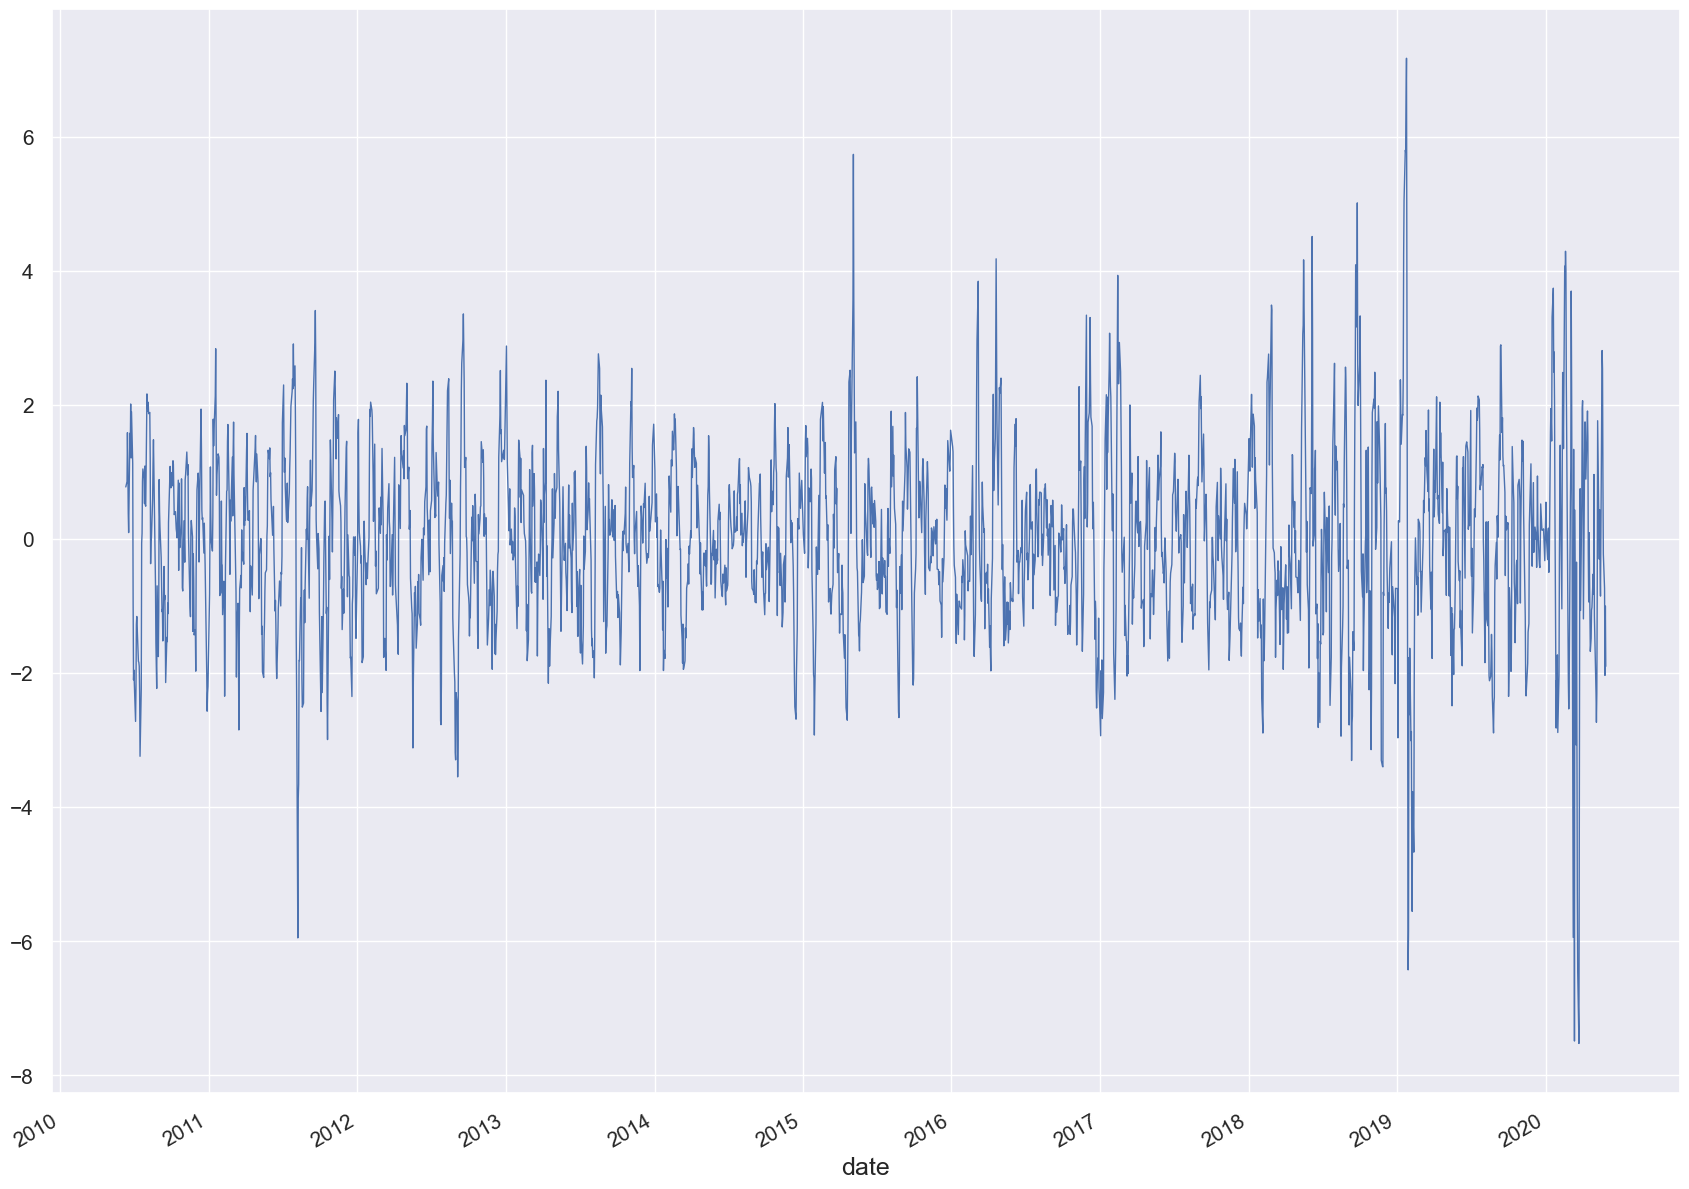

In [12]:
raw_df_without_trend = raw_df['price'] - trend
raw_df_without_trend.plot()

<AxesSubplot:xlabel='date'>

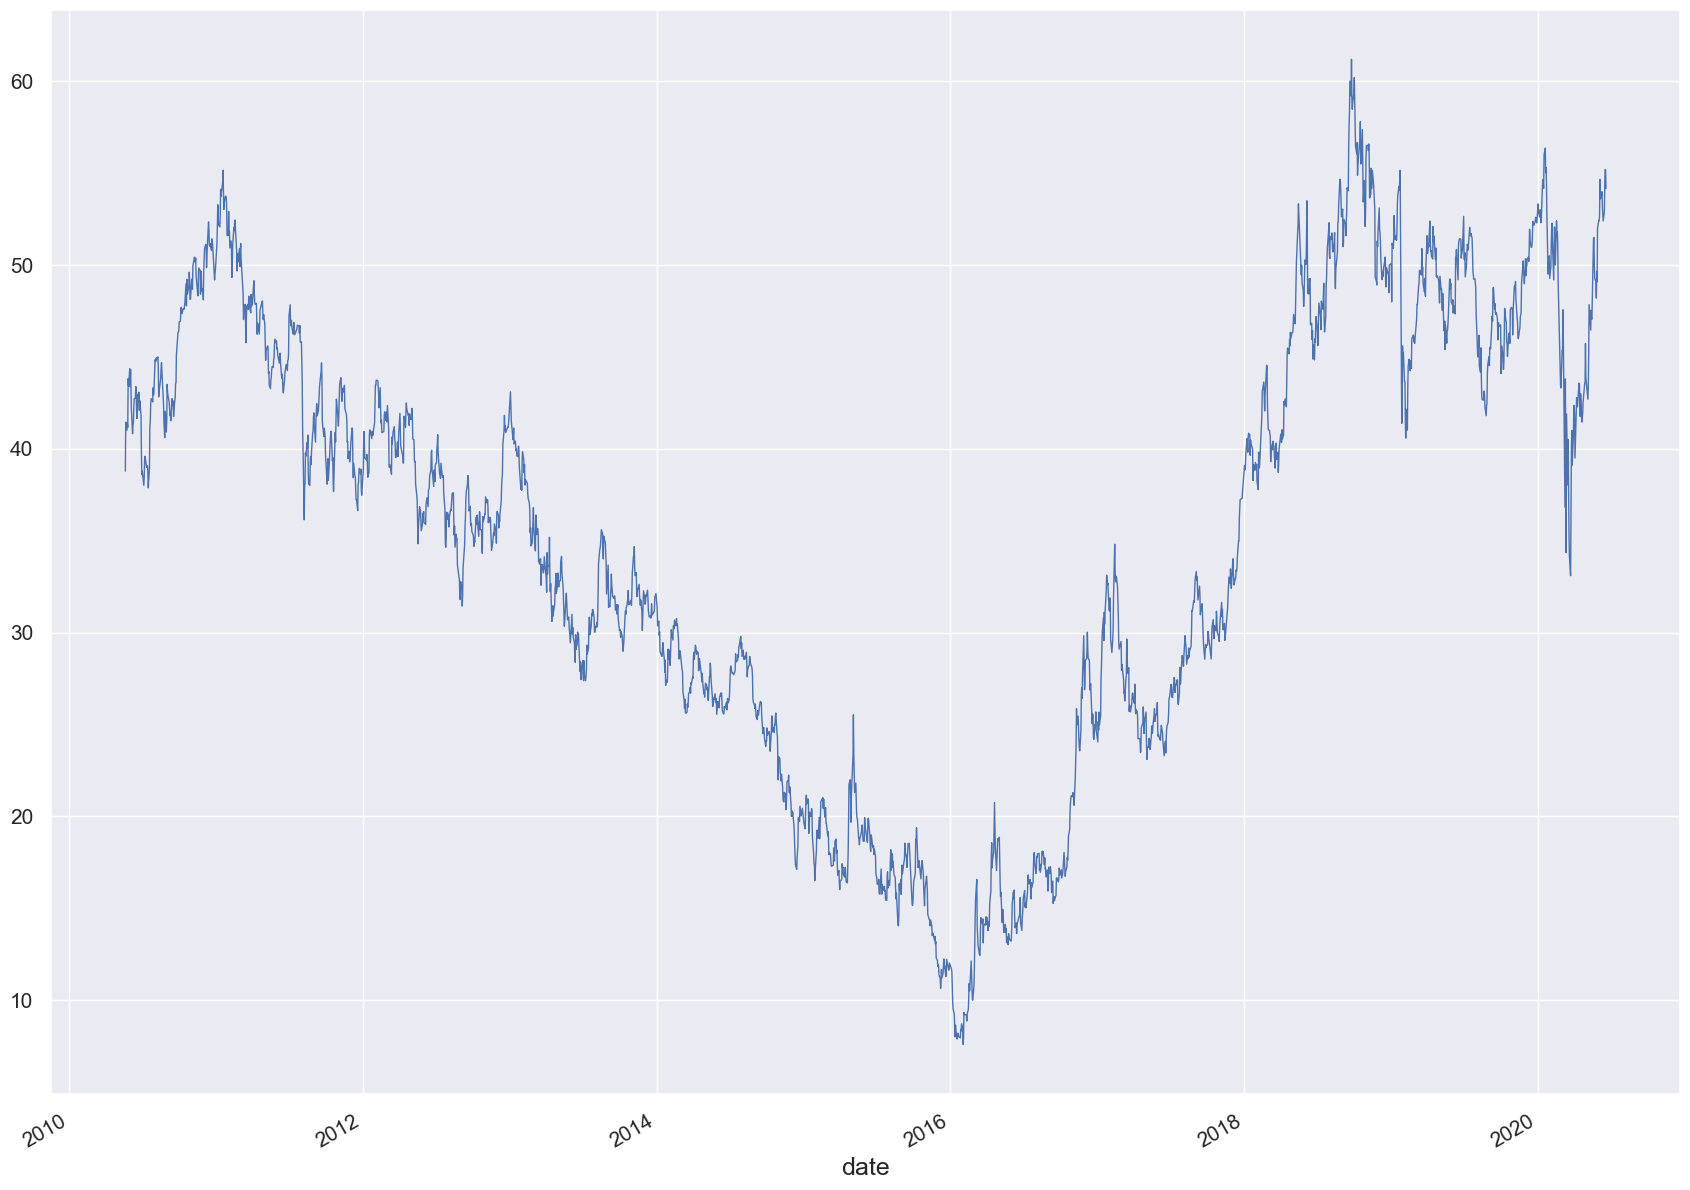

In [13]:
raw_df_without_seasonal = raw_df['price'] - seasonal
raw_df_without_seasonal.plot()

<AxesSubplot:xlabel='date'>

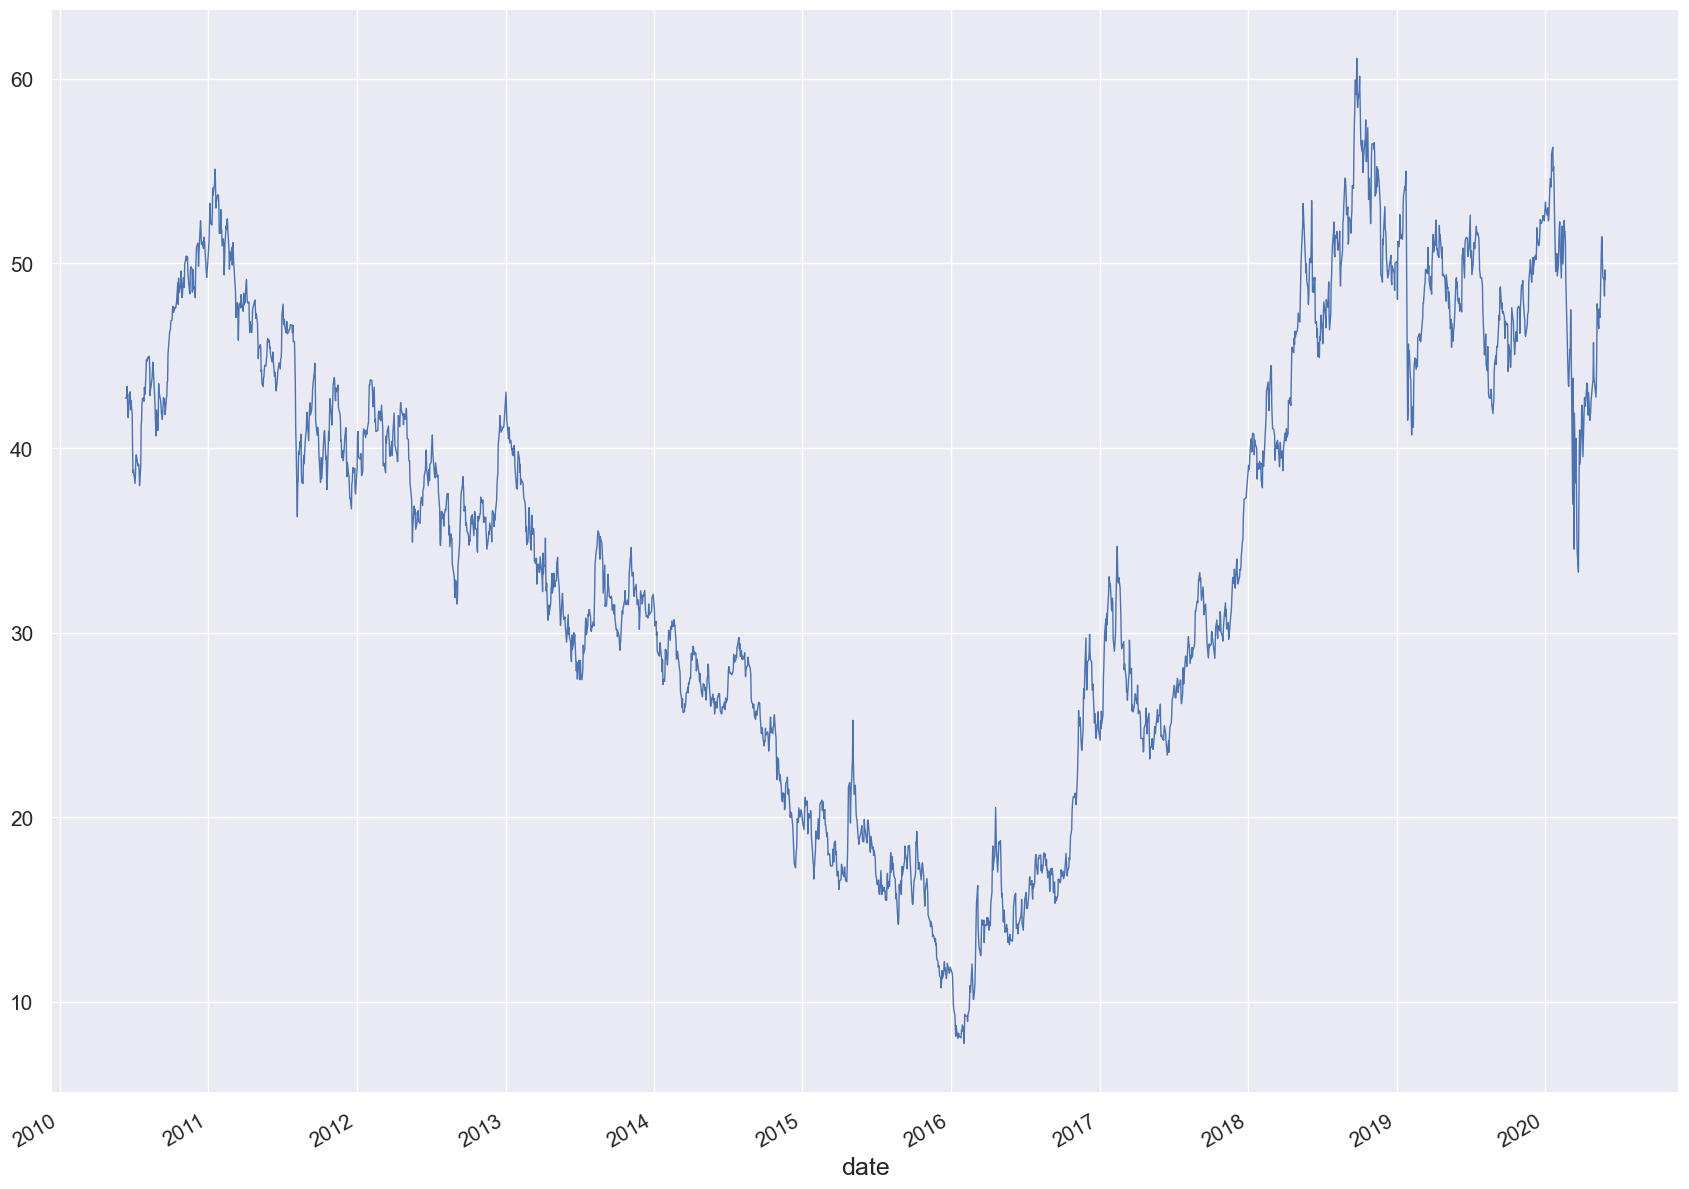

In [14]:
raw_df_without_resid = raw_df['price'] - residual
raw_df_without_resid.plot()

## Auto-correlation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

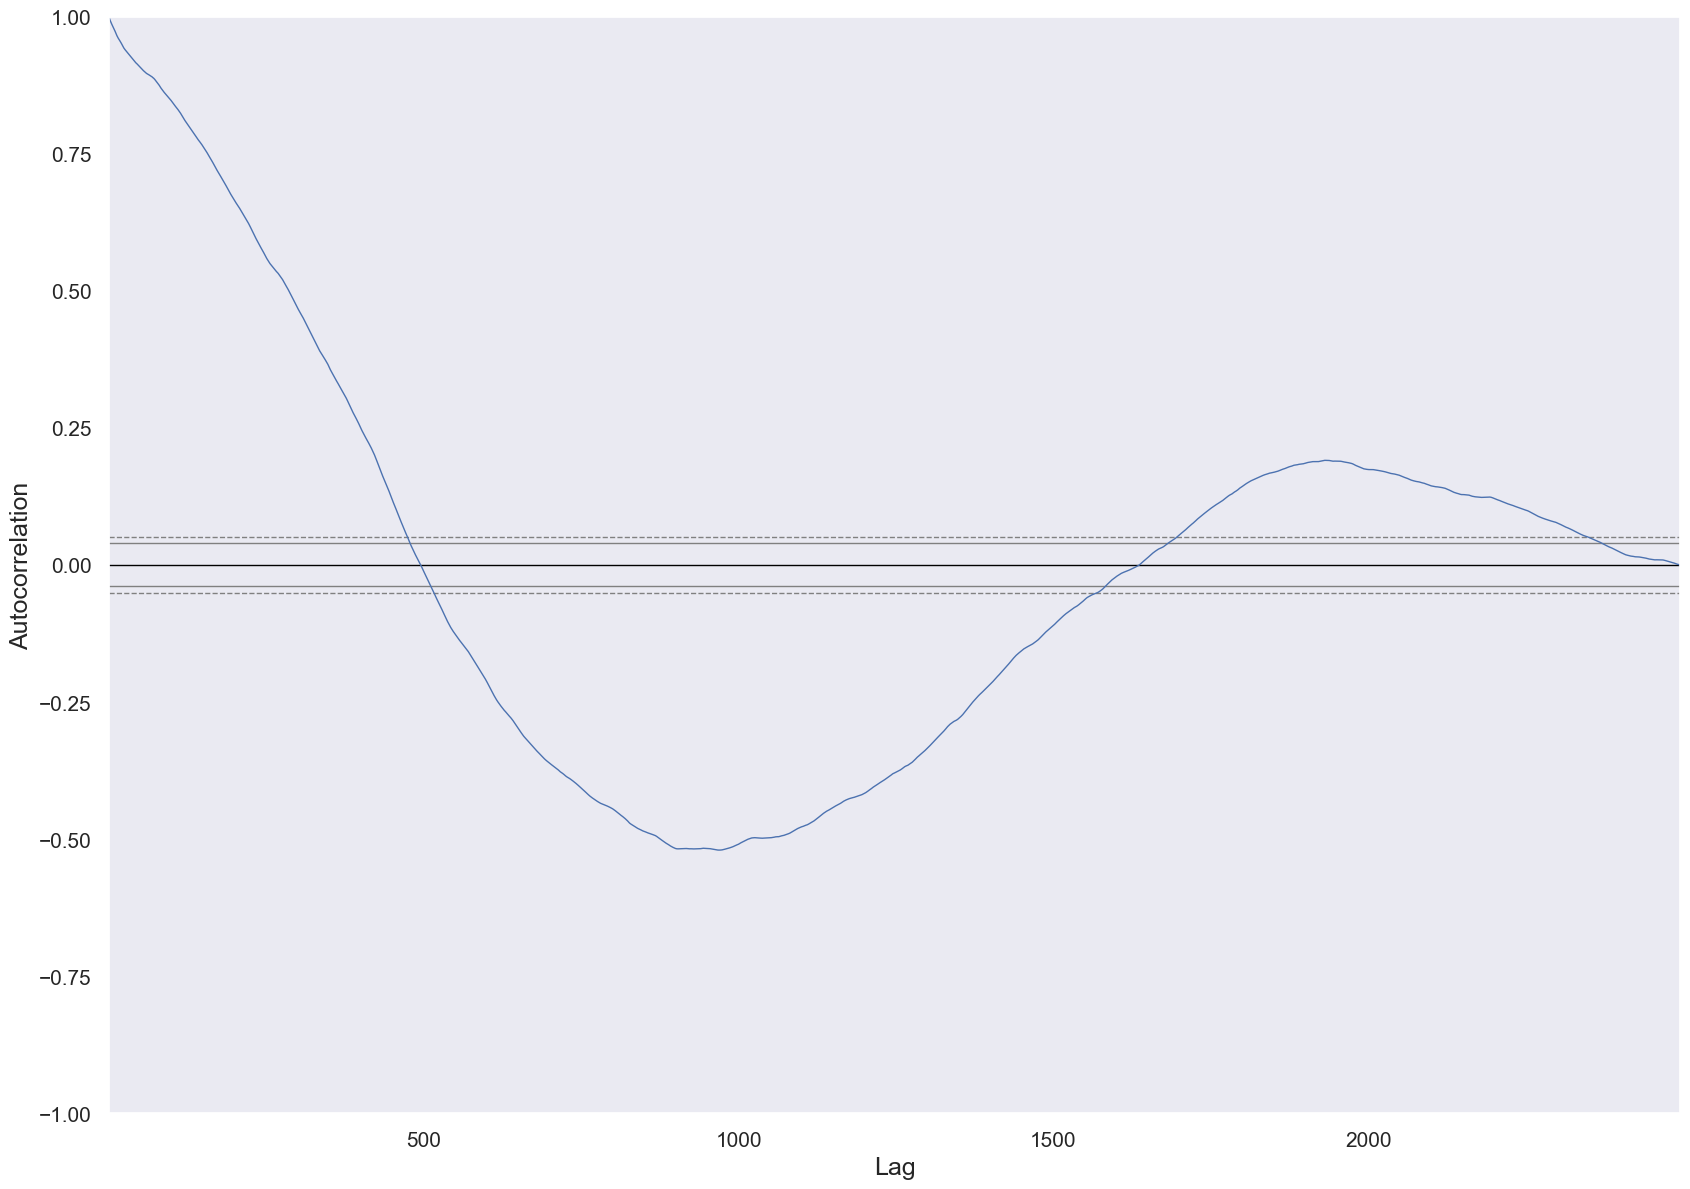

In [15]:
autocorrelation_plot(raw_df['price'])

In [16]:
single_day_autocorr = raw_df['price'].autocorr(lag = 1)
print(f'Autocorrelation with lag = 1: {single_day_autocorr}')

Autocorrelation with lag = 1: 0.9972513584845025


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

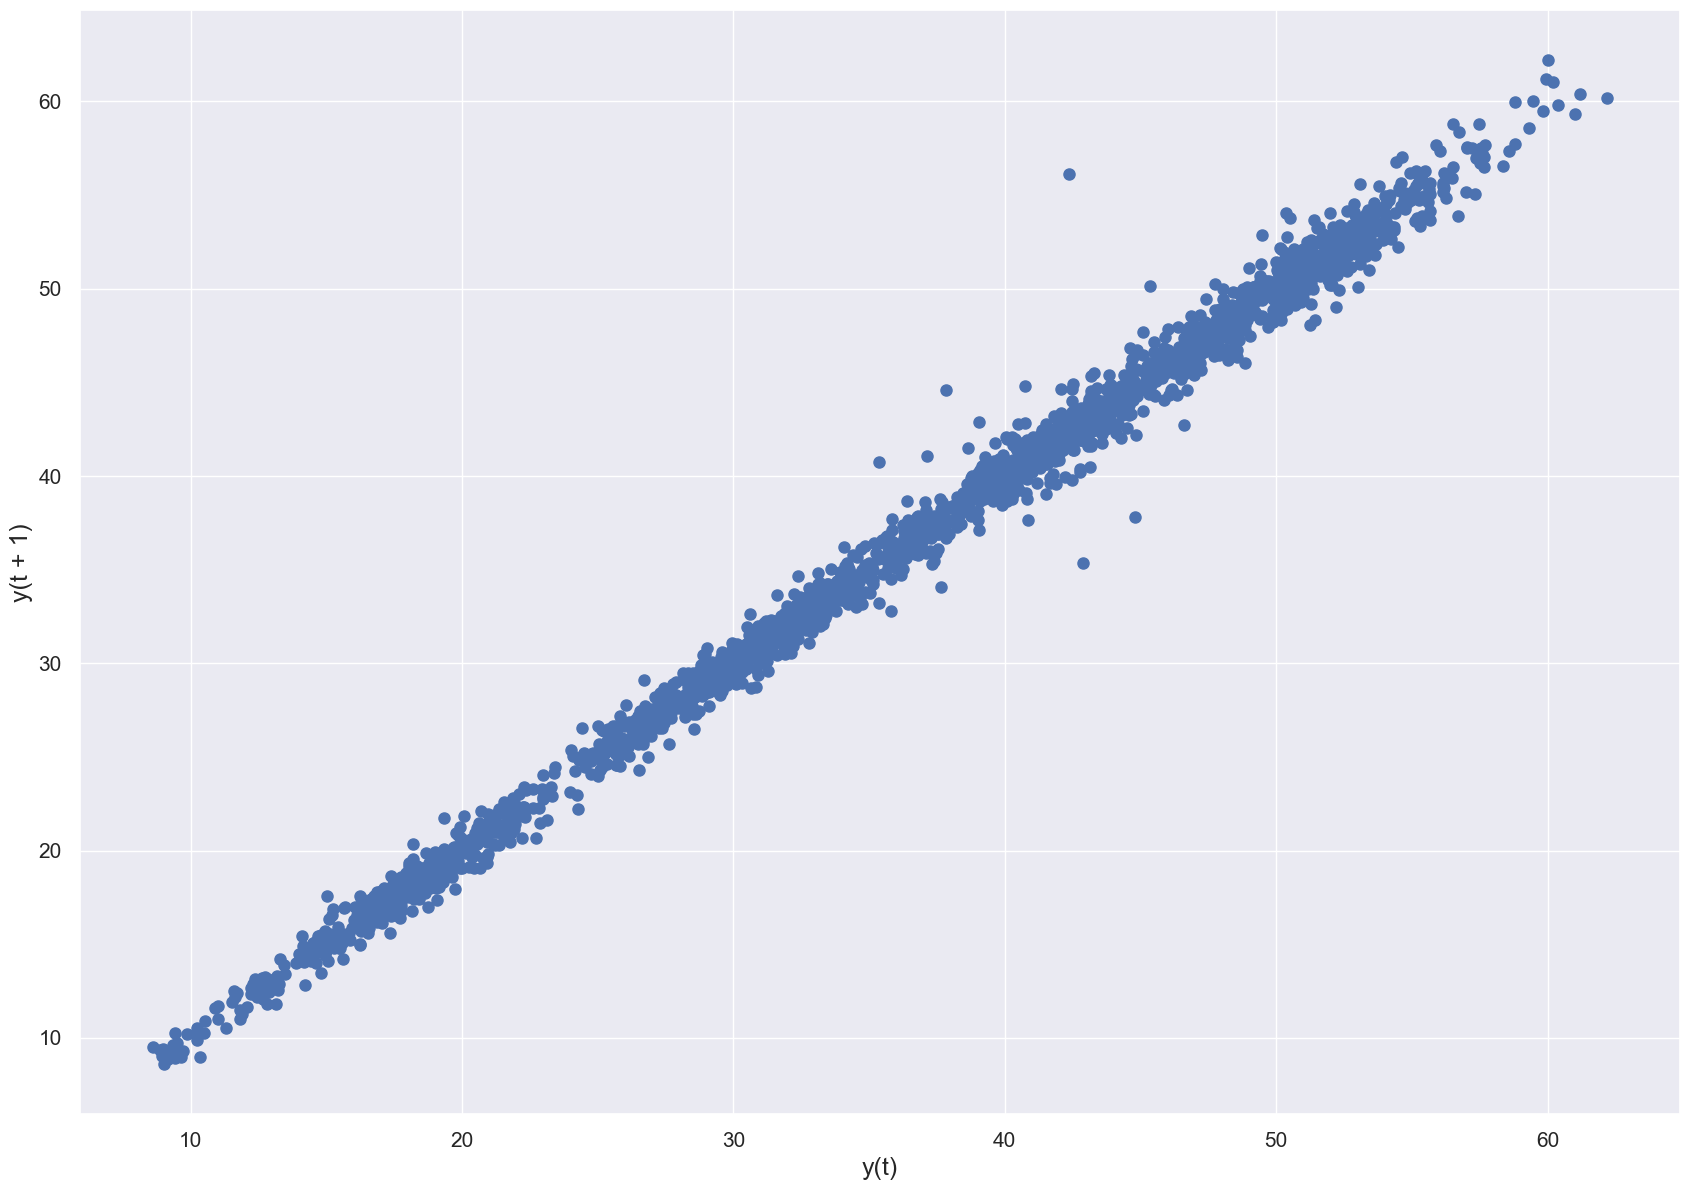

In [17]:
lag_plot(raw_df['price'], lag = 1)

In [18]:
season_window_autocorr = raw_df['price'].autocorr(lag = SEASON_WINDOW_SIZE)
print(f'Autocorrelation with lag = {SEASON_WINDOW_SIZE}: {season_window_autocorr}')

Autocorrelation with lag = 30: 0.9459357661702154


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 30)'>

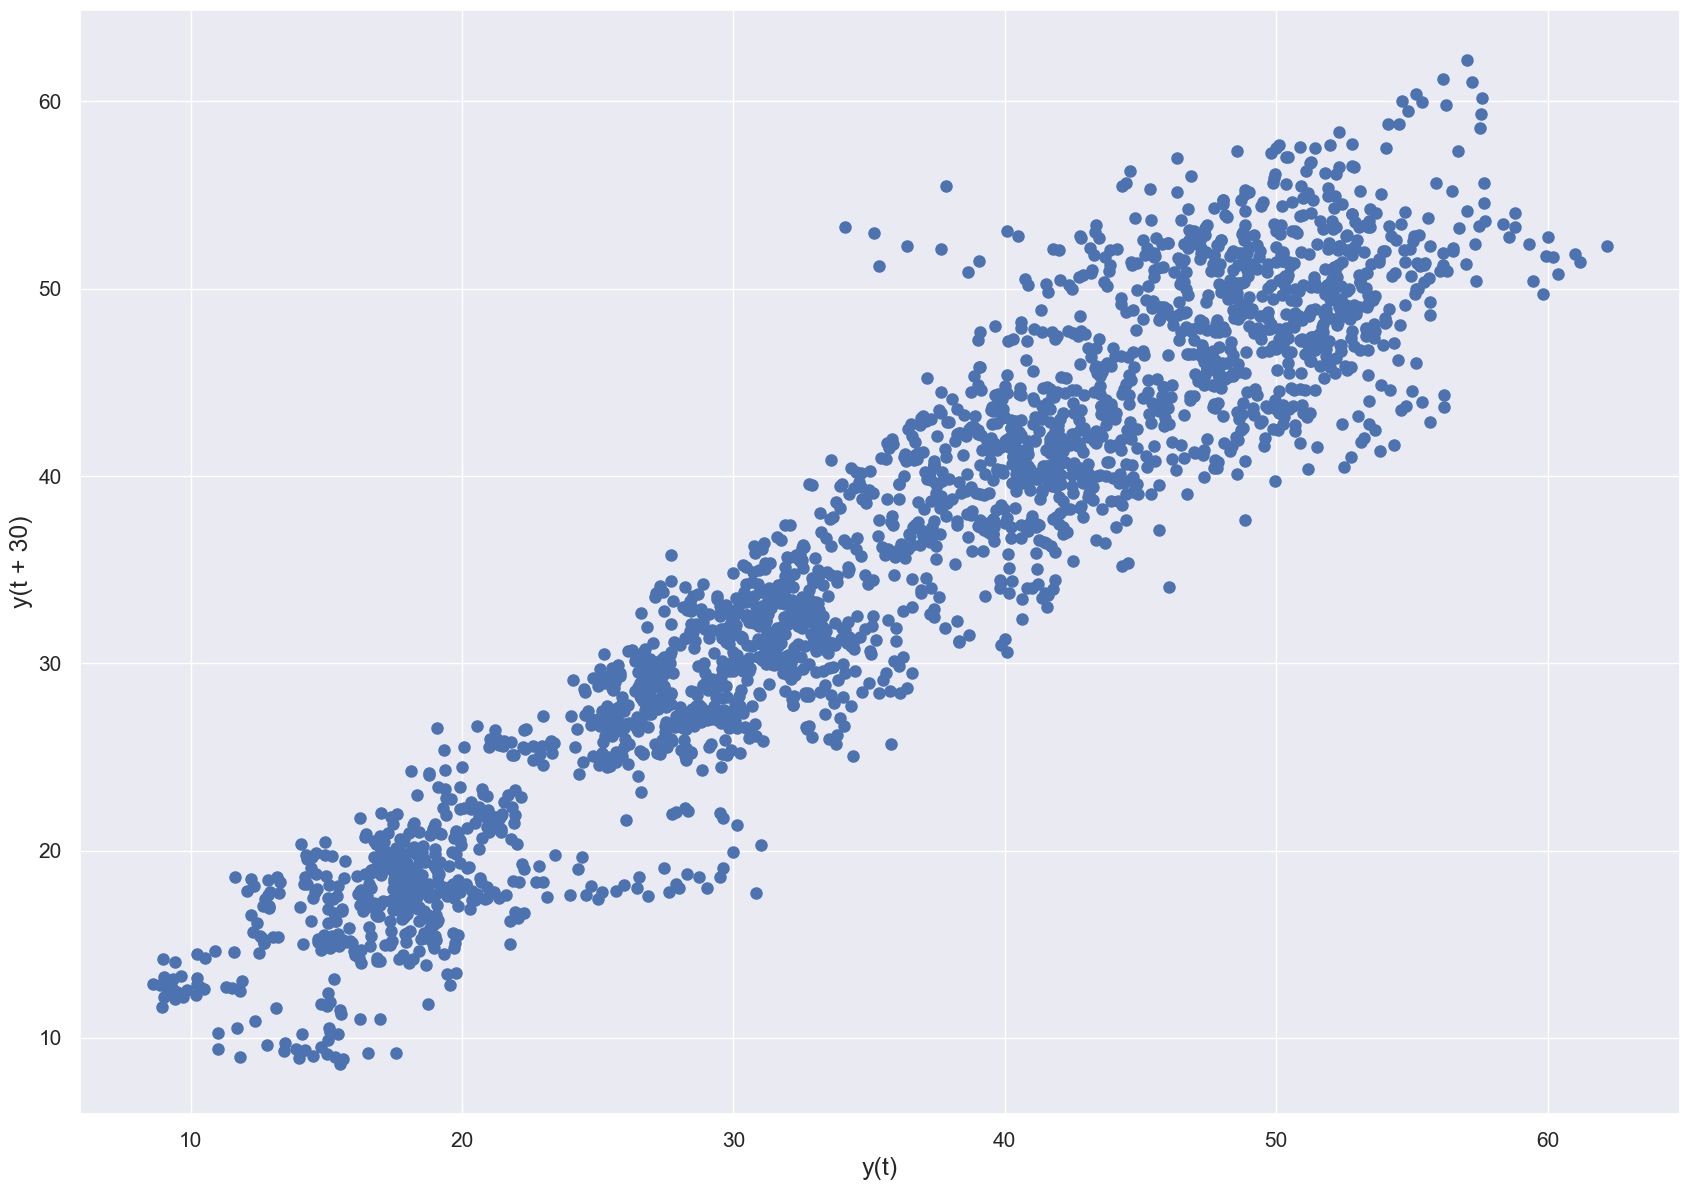

In [19]:
lag_plot(raw_df['price'], lag = SEASON_WINDOW_SIZE)

In [20]:
raw_df_original_lag = pd.concat([raw_df['price'], raw_df['price'].shift(SEASON_WINDOW_SIZE)], axis = 1)

## Stationarity

In [21]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window= SEASON_WINDOW_SIZE, center = False).mean()
    rolstd = timeseries.rolling(window= SEASON_WINDOW_SIZE, center = False).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = None)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value

    print(dfoutput)

### Original time series

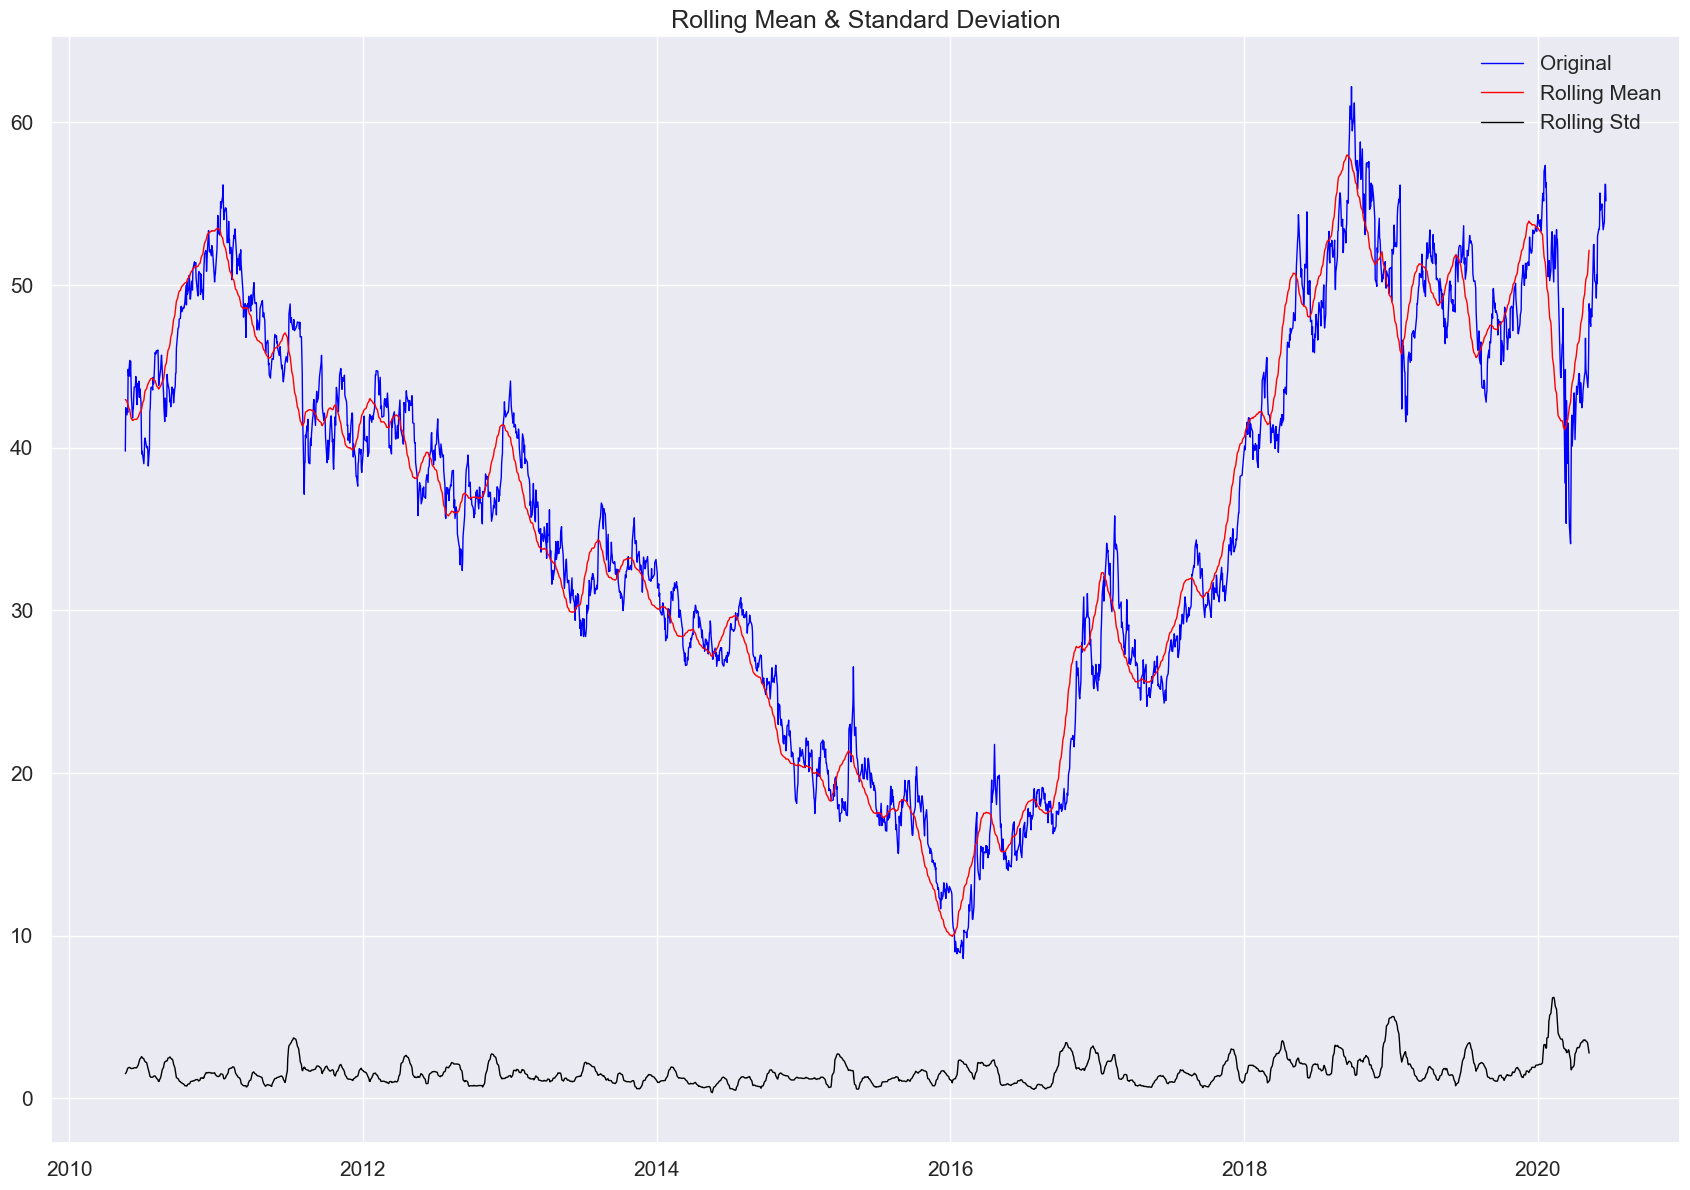

Results of Dickey-Fuller Test:
Test Statistic                  -1.51
p-value                          0.53
Lags Used                       27.00
Number of Observations Used   2467.00
Critical Value 1%               -3.43
Critical Value 5%               -2.86
Critical Value 10%              -2.57
dtype: float64


In [22]:
test_stationarity(raw_df['price'])

### Residuals time series

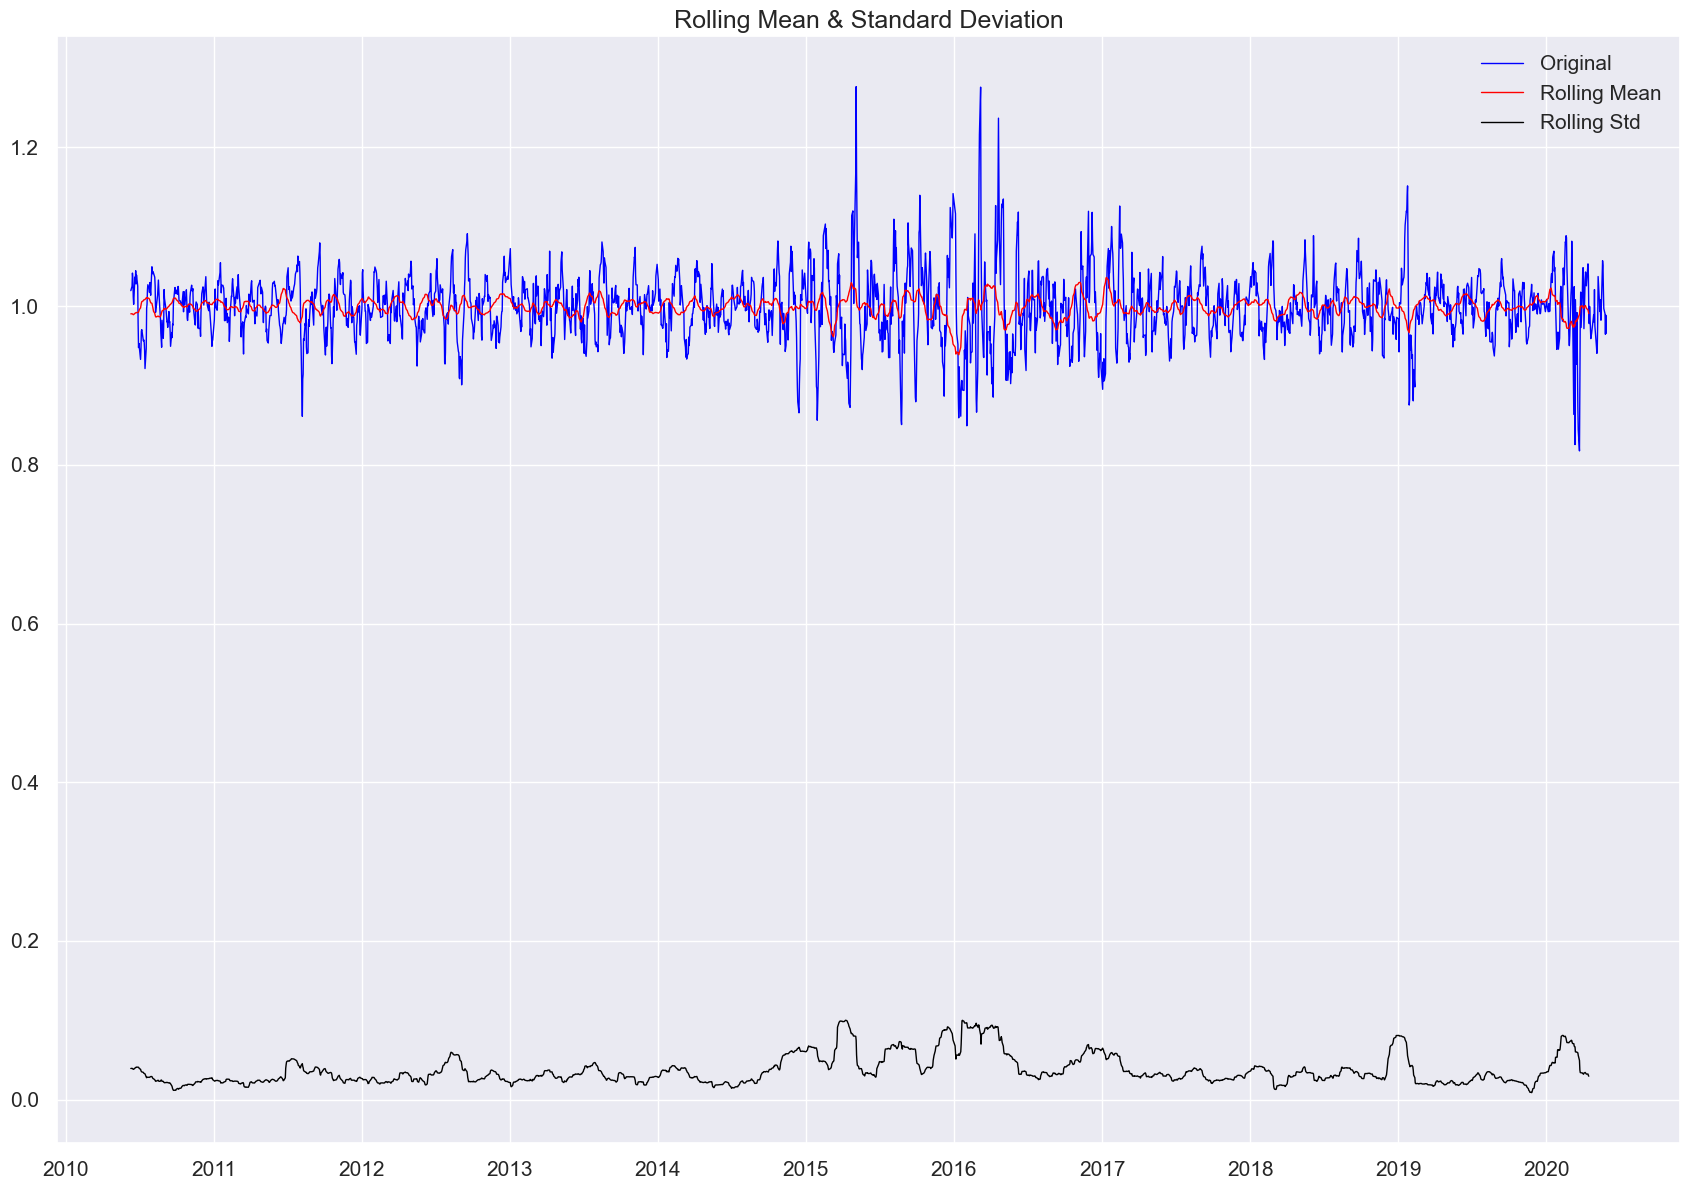

Results of Dickey-Fuller Test:
Test Statistic                 -12.42
p-value                          0.00
Lags Used                       27.00
Number of Observations Used   2437.00
Critical Value 1%               -3.43
Critical Value 5%               -2.86
Critical Value 10%              -2.57
dtype: float64


In [23]:
test_stationarity(residual.dropna())

## Data Preparation: Feature Engineering

In [24]:
cols = ['date', 'price', 'residuals', 'trend', 'seasonality']

In [25]:
df = pd.DataFrame(columns = cols)
df['date'] = raw_df['date']
df['price'] = raw_df['price']
df['residuals'] = residual.values
df['trend'] = trend.values
df['seasonality'] = seasonal.values

df_size = df.shape[0]
NAN_RANGE_SIZE = SEASON_WINDOW_SIZE // 2

df = df[NAN_RANGE_SIZE:df_size - NAN_RANGE_SIZE]
df.head()

,date,price,residuals,trend,seasonality
date,,,,,
2020-05-28,2020-05-28,50.09,0.97,51.99,1.00
2020-05-27,2020-05-27,50.64,0.99,51.64,0.99
2020-05-26,2020-05-26,49.20,0.96,51.24,1.00
2020-05-25,2020-05-25,50.10,0.99,50.84,1.00
2020-05-22,2020-05-22,50.27,1.00,50.50,1.00


#### Generate Diferrence

In [26]:
for i in range(1, DIFFERENCE_FEATURES_NUM + 1):
    df[f'diff_{i}'] = df['price'].diff(periods = i)

df.dropna(inplace=True)
df.head()

,date,price,residuals,trend,seasonality,diff_1
date,,,,,,
2020-05-27,2020-05-27,50.64,0.99,51.64,0.99,0.55
2020-05-26,2020-05-26,49.20,0.96,51.24,1.00,-1.44
2020-05-25,2020-05-25,50.10,0.99,50.84,1.00,0.90
2020-05-22,2020-05-22,50.27,1.00,50.50,1.00,0.17
2020-05-21,2020-05-21,51.13,1.02,50.23,1.00,0.86


In [27]:
df.to_csv(
    path_or_buf = PROCESSED_DATA_DIR + 'p_' + INPUT_FILE_NAME,
    sep = ',',
    index = False,
    encoding = 'utf8'
)